<a href="https://colab.research.google.com/github/ogunjosam/CARNASRDA_python_training/blob/main/Graphs_and_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graphs and plots

Our goal in this session is to:


1.   generate publication ready graphs from the Purpleair data
2.   export the generated graphs with world class aesthetics 



As usual, let's start by importing the necessary packages

In [11]:
!pip install purpleair
#!pip install cartopy

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy
#!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

import pandas as pd
from purpleair.sensor import Sensor
from purpleair.network import SensorList
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import seaborn as sns
import datetime
#import cartopy.crs as ccrs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Found existing installation: Shapely 1.8.1.post1
Uninstalling Shapely-1.8.1.post1:
  Successfully uninstalled Shapely-1.8.1.post1
  Using cached Shapely-1.8.1.post1.tar.gz (198 kB)
  Installing bui

Let's go back to our Osogbo data, shall we?

In [22]:
se = Sensor(57207)
df = se.parent.get_historical(5,thingspeak_field='primary')
df

df["created_at"] = pd.DatetimeIndex(df["created_at"])
dx = df.set_index('created_at')   #ds = df.resample(on='created_at',rule='H').mean()

Simple plot

Let's look at all the particulate matter in Osogbo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  


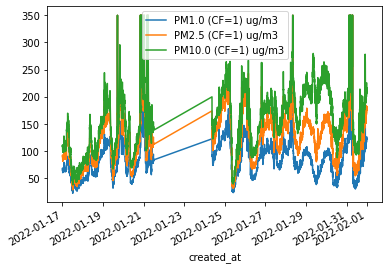

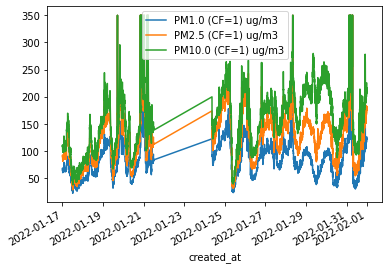

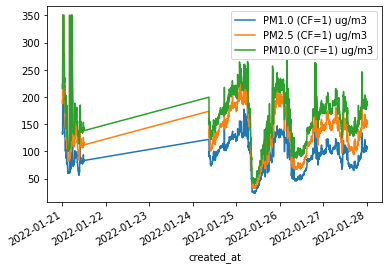

In [26]:
dx[['PM1.0 (CF=1) ug/m3','PM2.5 (CF=1) ug/m3','PM10.0 (CF=1) ug/m3']].plot()

dx[dx['PM10.0 (CF=1) ug/m3'] > 300] = 350
dx[['PM1.0 (CF=1) ug/m3','PM2.5 (CF=1) ug/m3','PM10.0 (CF=1) ug/m3']].plot()

dx = dx.loc['2022-1-21':'2022-1-27']
dx[['PM1.0 (CF=1) ug/m3','PM2.5 (CF=1) ug/m3','PM10.0 (CF=1) ug/m3']].plot()

Let's look at it another way

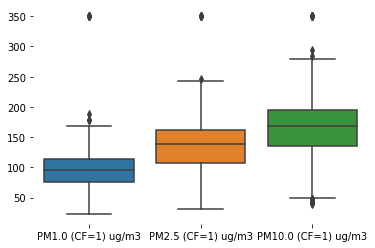

In [27]:
qq = dx[['PM1.0 (CF=1) ug/m3','PM2.5 (CF=1) ug/m3','PM10.0 (CF=1) ug/m3']]
sns.boxplot(data=qq)
sns.despine(left=True,bottom=True)  #offset int, trim = True

Let's look at the air quality in Osogbo

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


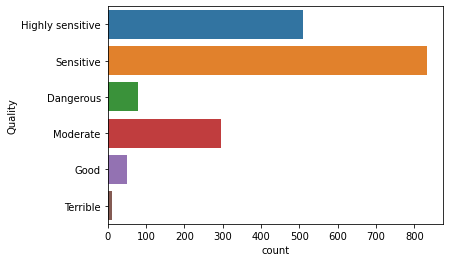

In [28]:
qq.loc[qq['PM2.5 (CF=1) ug/m3']<50,'Quality'] = 'Good'
qq.loc[qq['PM2.5 (CF=1) ug/m3'].between(51,100),'Quality'] = 'Moderate'
qq.loc[qq['PM2.5 (CF=1) ug/m3'].between(101,150),'Quality'] = 'Sensitive'
qq.loc[qq['PM2.5 (CF=1) ug/m3'].between(151,200),'Quality'] = 'Highly sensitive'
qq.loc[qq['PM2.5 (CF=1) ug/m3'].between(201,300),'Quality'] = 'Dangerous'
qq.loc[qq['PM2.5 (CF=1) ug/m3']>300,'Quality'] = 'Terrible'

sns.countplot(y='Quality',data=qq)


What is the relationship between all the variables?

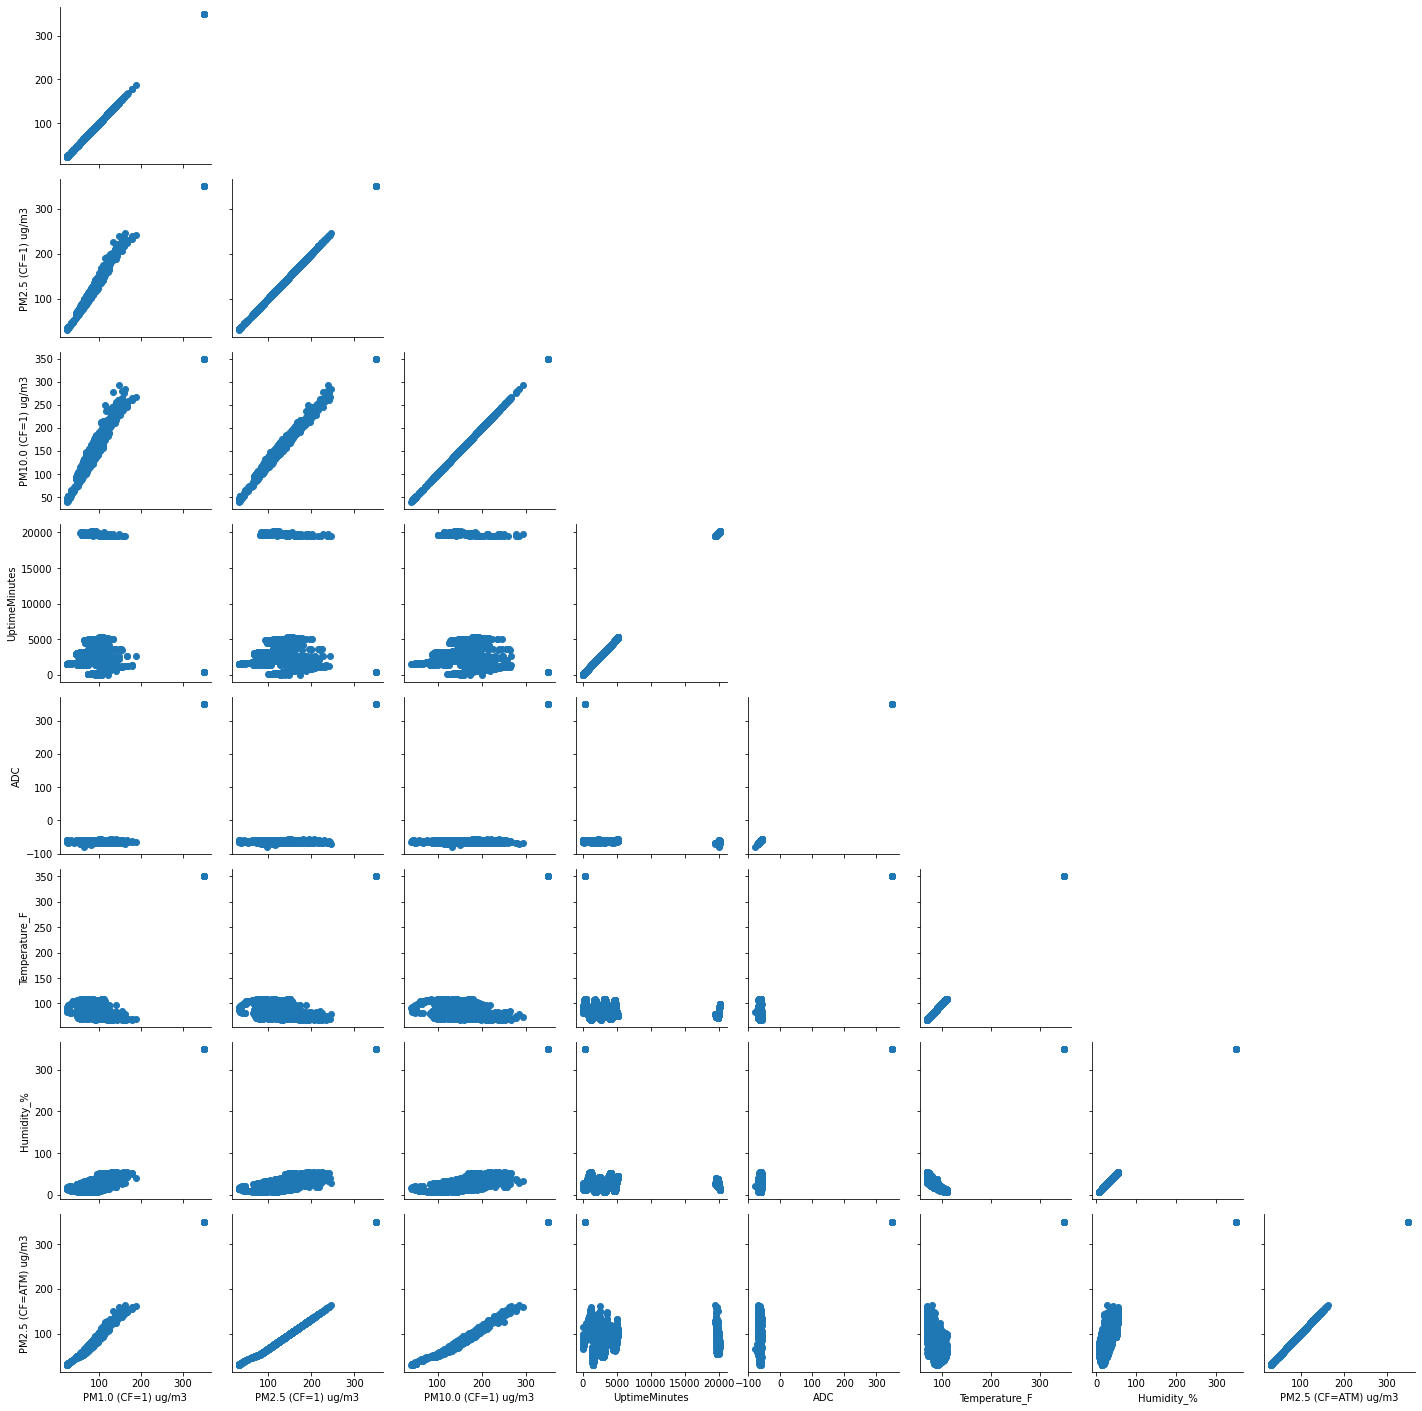

In [29]:
g = sns.PairGrid(dx,corner=True,despine=True)
g.map(plt.scatter);
#g.map_diag(sns.kdeplot)
#g.map_upper(sns.scatterplot)
plt.show()

How about temperature and relative humidity on different y-axis?

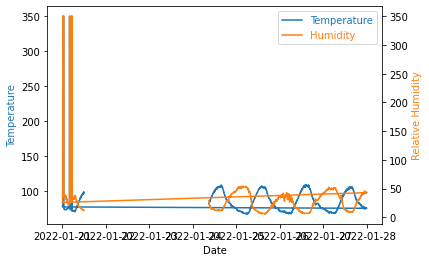

<Figure size 432x288 with 0 Axes>

In [30]:
host = host_subplot(111)

par = host.twinx()

host.set_xlabel("Date")
host.set_ylabel("Temperature")
par.set_ylabel("Relative Humidity")

p1, = host.plot(dx['Temperature_F'], label="Temperature")
p2, = par.plot(dx['Humidity_%'], label="Humidity")

leg = plt.legend()

host.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()
plt.savefig('fig2.eps',dpi=1200,format='eps',bbox_inches="tight")

Is it possible to do a spatial plot?

Child 2861 lists parent 2860, but parent does not exist!
Initialized 22,433 sensors!


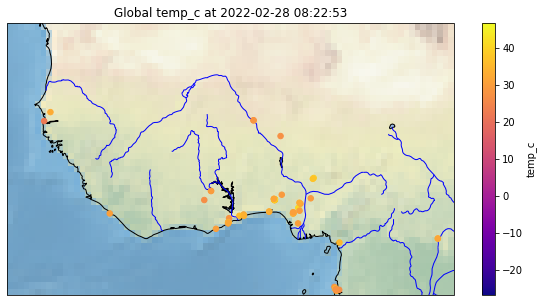

In [48]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
VAR_TO_VIZ = 'temp_c'  # The dict item that we want to visualize

# Get PurpleAir data
p = SensorList()
df = p.to_dataframe('all', 'parent')
df = df[df['temp_c'] <= 50]

# Store the lat and lon coords to plot
lat = df['lat'].values
lon = df['lon'].values

# Variable from which to generate the color gradient
colors = df[VAR_TO_VIZ].values

# Create the figure and the axes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Display some map info
#ax.set_global()  # Show whole globe - Africa [-40, 20, 30, 60]  ax.set_extent(extent)
ax.set_extent([-20, 20, 0, 20])
ax.stock_img()  # Use default background image
ax.coastlines(resolution='50m')  # Draw coastlines with higher contrast

# Add scatter points for each coordinate pair
scatter = ax.scatter(lon, lat, marker='o', c=colors, cmap='plasma', zorder=5, s=30)

# Add scale
sm = plt.cm.ScalarMappable(cmap='plasma') 
cb = plt.colorbar(scatter).set_label(f'{VAR_TO_VIZ}', rotation=90)

# Draw title and save
ax.set_aspect('auto', adjustable=None)
plt.title(
    f'Global {VAR_TO_VIZ} at {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS,facecolor='None', edgecolor='b')